In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import random
from sklearn.metrics import accuracy_score

import requests, zipfile, io, json
import os, glob
import shutil

print(tf.__version__)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

2.9.1
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5


In [2]:
data_dir = './data/sarcasm/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

url='https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json'
with requests.get(url) as data:
    data.raise_for_status()
    print(data.json()[:3])
    
    with open(os.path.join(data_dir, 'sarcasm.json'), 'wt') as file:
        json.dump(data.json(), file)

            
print(os.listdir(data_dir))

[{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5', 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers", 'is_sarcastic': 0}, {'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365', 'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse", 'is_sarcastic': 0}, {'article_link': 'https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697', 'headline': "mom starting to fear son's web series closest thing she will have to grandchild", 'is_sarcastic': 1}]
['.ipynb_checkpoints', 'sarcasm.json']


In [3]:
with open(os.path.join(data_dir, 'sarcasm.json'), 'r') as f:
    datastore = json.load(f)

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

print(len(sentences), len(labels))

26709 26709


In [4]:
TRAINING_SIZE = int(len(sentences) * 0.15)

training_sentences = sentences[TRAINING_SIZE:]
training_labels = labels[TRAINING_SIZE:]
testing_sentences = sentences[:TRAINING_SIZE]
testing_labels = labels[:TRAINING_SIZE]

len(training_sentences), len(training_labels), len(testing_sentences), len(testing_labels),

(22703, 22703, 4006, 4006)

In [13]:
vocab_size = 5000
max_length = 16
embedding_dim = 24
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
SHUFFLE_SIZE=len(training_sentences) // 2
BATCH_SIZE = 32
EPOCHS = 50 
PATIENCE = 5
MONITOR = 'val_acc'

In [14]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = tf.keras.preprocessing.sequence.pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = tf.keras.preprocessing.sequence.pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

xtrain = tf.data.Dataset.from_tensor_slices(training_padded)
ytrain = tf.data.Dataset.from_tensor_slices(training_labels)
print(xtrain, ytrain)

train_dataset = tf.data.Dataset.zip((xtrain, ytrain)).shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print(train_dataset, '\n\n')

xtest = tf.data.Dataset.from_tensor_slices(testing_padded)
ytest = tf.data.Dataset.from_tensor_slices(testing_labels)
print(xtest, ytest)

test_dataset = tf.data.Dataset.zip((xtest, ytest)).shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print(test_dataset, '\n\n')

<TensorSliceDataset element_spec=TensorSpec(shape=(16,), dtype=tf.int32, name=None)> <TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 16), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> 


<TensorSliceDataset element_spec=TensorSpec(shape=(16,), dtype=tf.int32, name=None)> <TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 16), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> 




In [15]:
# Initialize a GlobalAveragePooling1D (GAP1D) layer
gap1d_layer = tf.keras.layers.GlobalAveragePooling1D()

# Define sample array
sample_array = np.array([
    [
        [10,2],
        [1,3],
        [1,1]
    ]
])

# Print shape and contents of sample array
print(f'shape of sample_array = {sample_array.shape}')
print(f'sample array: {sample_array}')

# Pass the sample array to the GAP1D layer
output = gap1d_layer(sample_array)

# Print shape and contents of the GAP1D output array
print(f'output shape of gap1d_layer: {output.shape}')
print(f'output array of gap1d_layer: {output.numpy()}')

shape of sample_array = (1, 3, 2)
sample array: [[[10  2]
  [ 1  3]
  [ 1  1]]]
output shape of gap1d_layer: (1, 2)
output array of gap1d_layer: [[4 2]]


In [16]:
MODEL_NAME = './models/SarcasmClassification_embidding_flattened_full_verse.h5'

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Setup the training parameters
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=tf.keras.optimizers.Nadam(1e-3),
    metrics=['acc']
)

# Print the model summary
print(model.summary())

callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor=MONITOR, factor=0.1, patience=PATIENCE, min_lr=1e-5)]
callbacks += [tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, monitor=MONITOR, save_best_only=True)]
callbacks += [tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE*2, restore_best_weights=True)]

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=test_dataset,
    callbacks=callbacks
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 16, 24)            120000    
                                                                 
 flatten_1 (Flatten)         (None, 384)               0         
                                                                 
 dense_4 (Dense)             (None, 24)                9240      
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 129,265
Trainable params: 129,265
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
710/710 [==============================] - 7s 9ms/step - loss: 0.4180 - acc: 0.7973 - val_loss: 0.3244 - val_acc: 0.8540 - lr: 0.0010
Epoch 2/50
710/710 [==========

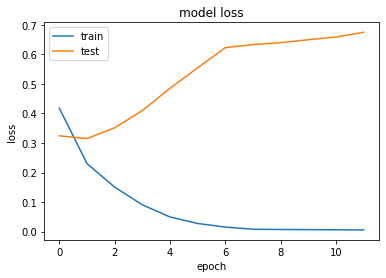

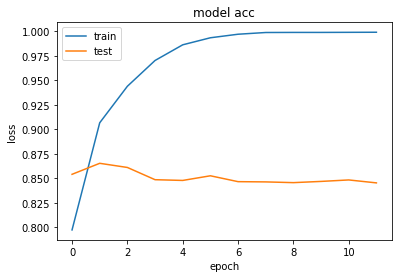

In [17]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
MODEL_NAME = './models/SarcasmClassification_embidding_global_pooling_full_verse.h5'

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Setup the training parameters
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=tf.keras.optimizers.Nadam(1e-3),
    metrics=['acc']
)

# Print the model summary
print(model.summary())

callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor=MONITOR, factor=0.1, patience=PATIENCE, min_lr=1e-5)]
callbacks += [tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, monitor=MONITOR, save_best_only=True)]
callbacks += [tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE*2, restore_best_weights=True)]

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=test_dataset,
    callbacks=callbacks
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 16, 24)            120000    
                                                                 
 global_average_pooling1d_3   (None, 24)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 24)                600       
                                                                 
 dense_7 (Dense)             (None, 1)                 25        
                                                                 
Total params: 120,625
Trainable params: 120,625
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
710/710 [==============================] - 7s 9ms/step - loss: 0.4863 - acc: 0.7671 - val_loss: 0.

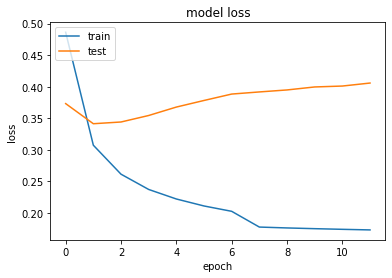

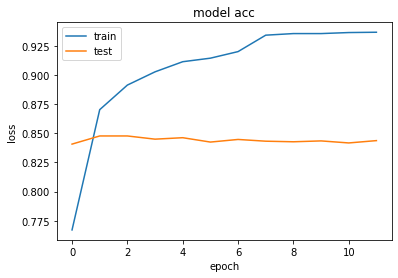

In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()